In [0]:
%%capture
#Install
!pip install -U ftfy
!pip install -U empath
!pip install -U networkx
!pip install -U liwc-text-analysis

In [2]:
from google.colab import drive
import pandas as pd
import cufflinks as cf
import chart_studio.plotly as py
import plotly.graph_objs as go
import numpy as np
import networkx as nx
from plotly.offline import iplot
import ftfy
from liwc import Liwc
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
from collections import Counter

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

drive.mount('/content/drive')
nltk.download('punkt')
cf.go_offline()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#get_ipython().events.register('pre_run_cell', enable_plotly_in_cell)
#get_ipython().events.unregister('pre_run_cell', enable_plotly_in_cell)


In [16]:
labeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/claff-offmychest-master/data/training data/labeled_training_set.csv",sep=",",dtype={"sentenceid":"int"})
unlabeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/claff-offmychest-master/data/unlabeled data/comments_score_unlabeled.csv",sep=",",dtype={"indexid":"int","created_utc":"int"})
labeled_comments.columns=labeled_comments.columns.str.lower()
unlabeled_comments.columns=unlabeled_comments.columns.str.lower()
unlabeled_comments.rename(columns={'v1': 'full_text','label':'tags'}, inplace=True)
labeled_comments.rename(columns={'label':'tags'}, inplace=True)
labeled_comments['disclosive'] = labeled_comments['emotional_disclosure'] | labeled_comments['information_disclosure']

labeled_comments.head(5)
unlabeled_comments.head(5)

,indexid,author,nchar,created_utc,score,subreddit,tags,full_text,wordcount,id,sentenceid
0,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,You are quite the writer and have a deep sense...,15,91px39,1
1,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,May your life continue to be rewarding.,7,91px39,2
2,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,"I<U+0092>m glad you shared your story, thank you.",8,91px39,3
3,1,plspmmepuppies,185,1532510019,566,offmychest,husband boyfriend,I love how deep this is.,6,91px39,4
4,1,plspmmepuppies,185,1532510019,566,offmychest,husband boyfriend,One of the most touching things I<U+0092>ve ev...,12,91px39,5


# Data Cleaning

Comments seem to come with weird artefacts, such as remaining unicode blocks (e.g. <U+0092>) and html entities so I intend to use some regex to pattern match and use html.unescape to fix these.

Update: using a library ftfy to fix text



In [17]:
#@title panel
i=222 #@param {type:"integer"}

import re
pat1 = re.compile(r'<U?\+?[0-9A-F]{,7}>')
pat2 = re.compile(r'<U\+[0-9A-F]{8,}>')

def unirepl(mobj):
    n=int(mobj.group()[3:-1],16)
    return chr(n)

labeled_comments['full_text']=labeled_comments['full_text'].str.replace(pat1,unirepl)
labeled_comments['full_text']=labeled_comments['full_text'].apply(lambda x: ftfy.fix_text(x,fix_entities=True))
labeled_comments['full_text']=labeled_comments['full_text'].str.replace(pat2,unirepl)
unlabeled_comments['full_text']=unlabeled_comments['full_text'].str.replace(pat1,unirepl)
unlabeled_comments['full_text']=unlabeled_comments['full_text'].apply(lambda x: ftfy.fix_text(x,fix_entities=True))
unlabeled_comments['full_text']=unlabeled_comments['full_text'].str.replace(pat2,unirepl)
unlabeled_comments.head()


,indexid,author,nchar,created_utc,score,subreddit,tags,full_text,wordcount,id,sentenceid
0,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,You are quite the writer and have a deep sense...,15,91px39,1
1,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,May your life continue to be rewarding.,7,91px39,2
2,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,"I'm glad you shared your story, thank you.",8,91px39,3
3,1,plspmmepuppies,185,1532510019,566,offmychest,husband boyfriend,I love how deep this is.,6,91px39,4
4,1,plspmmepuppies,185,1532510019,566,offmychest,husband boyfriend,One of the most touching things I've ever read...,12,91px39,5


Turns out html entities are likely to be from reddit markdown so the markdown needs to be parsed and removed

https://jiangnanhugo.github.io/2017/Clean-Reddit-texts-with-markdown-and-emoticons/

In [15]:
re.sub(r'(?<!\\)\[(?P<link>.+?)\]\((?P<url>.+)\)?',LINK_SUB,"I always appreciate them after I listen to [Sunday Morning Comedown](https://www.youtube.com/watch?")

'I always appreciate them after I listen to Sunday Morning Comedown'

In [18]:
from collections import OrderedDict


EMPHASIS_RE = r'([_\*])([^\*]+)\1'
EMPHASIS_SUB = r'\2'
# **strong**
STRONG_RE = r'(\*{2}|_{2}|\~{2 })(.+?)\1'
STRONG_SUB = r'\2'
# [text](url) or [text](<url>) or [text](url "title")
LINK_RE=r'(?<!\\)\[(?P<link>.+?)\]\((?P<url>.+)?\)?'
LINK_SUB=r'\1'
# ![alltext](http://x.com) or ![alttext](<http://x.com/>)
IMAGE_LINK_RE=r'\!(?<!\\)\[(?P<link>.+?)\]\((?P<url>.+)?\)?'
IMAGE_LINK_SUB=r'\1'
# <me@example.com>
AUTOMAIL_RE=r'<([^> \!]*@[^> ]*)>'
AUTOMAIL_SUB=' this email '
URL_RE=r"((?:[Ff]|[Hh][Tt])[Tt][PpDIGITS=][Ss]?://[^>]*)"
URL_SUB=r' [url] '

# html tokens
HTML_RE=r"(&[\#a-zA-Z0-9]*;)"
HTML_SUB=r""
# repeated word character, like: Nachoooooo WOOOOOSHHHH
REPEATED_RE=r"([\w\.])\1{2,}"
REPEATED_SUB=r"\1\1"
#get rid of escaped chars in markdown
BACK_RE = r"\\[\\\_\+\-\*]"
BACK_SUB = r""
#superscript
SUPER_RE = r"\^([A-Za-z0-9]+\b)"
SUPER_SUB = r"\1"


def build_inlinepatterns():
    inline_patterns = OrderedDict()
    inline_patterns['backslashes'] = (BACK_RE, BACK_SUB)
    inline_patterns['strong'] = (STRONG_RE, STRONG_SUB)
    inline_patterns['emphasis'] = (EMPHASIS_RE, EMPHASIS_SUB)
    inline_patterns['automail'] = (AUTOMAIL_RE, AUTOMAIL_SUB)
    inline_patterns['image_link'] = (IMAGE_LINK_RE, IMAGE_LINK_SUB)
    inline_patterns['link'] = (LINK_RE, LINK_SUB)
    inline_patterns['url'] = (URL_RE, URL_SUB)
    inline_patterns['html'] = (HTML_RE, HTML_SUB)
    inline_patterns['superscript'] = (SUPER_RE, SUPER_SUB)
    
    return inline_patterns

pattern_dict = build_inlinepatterns()

for key in pattern_dict:
    (patt, sub)=pattern_dict[key]
    patt = re.compile(patt)
    labeled_comments['full_text']=labeled_comments['full_text'].str.replace(patt,sub)
    print(key,labeled_comments['full_text'][16])
    unlabeled_comments['full_text']=unlabeled_comments['full_text'].str.replace(patt,sub)

unlabeled_comments.head()

backslashes You know it seems like what Ford said was true...
strong You know it seems like what Ford said was true...
emphasis You know it seems like what Ford said was true...
automail You know it seems like what Ford said was true...
image_link You know it seems like what Ford said was true...
link You know it seems like what Ford said was true...
url You know it seems like what Ford said was true...
html You know it seems like what Ford said was true...
superscript You know it seems like what Ford said was true...


,indexid,author,nchar,created_utc,score,subreddit,tags,full_text,wordcount,id,sentenceid
0,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,You are quite the writer and have a deep sense...,15,91px39,1
1,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,May your life continue to be rewarding.,7,91px39,2
2,0,stinkbugsinfest,174,1532508063,1906,offmychest,husband boyfriend,"I'm glad you shared your story, thank you.",8,91px39,3
3,1,plspmmepuppies,185,1532510019,566,offmychest,husband boyfriend,I love how deep this is.,6,91px39,4
4,1,plspmmepuppies,185,1532510019,566,offmychest,husband boyfriend,One of the most touching things I've ever read...,12,91px39,5


Many comments are not actual conversations but are mod comments about upholding the rules of the sub, so it makes sense to delete these.\
Done heuristically by noting that CasualConversation mod comments tend to start with 'Thank you for your submission!'

In [19]:
unlabeled_comments.full_text[159483]

'┻━┻ ︵ヽ(`Д´)ノ︵ ┻━┻  FREEEEEEEEEEEEEEDOM!'

In [0]:
unlabeled_comments = unlabeled_comments[~unlabeled_comments['indexid'].isin(unlabeled_comments[unlabeled_comments['full_text'].str.startswith('Thank you for your submission!')]['indexid'])]
unlabeled_comments = unlabeled_comments[~unlabeled_comments['indexid'].isin(unlabeled_comments[unlabeled_comments['full_text'].str.contains('I just wanted to reach out because of your recent submission on CasualConversation')]['indexid'])]
unlabeled_comments = unlabeled_comments[~unlabeled_comments['indexid'].isin(unlabeled_comments[unlabeled_comments['full_text'].str.contains('Unfortunately, it has been removed for the following reason')]['indexid'])]

unlabeled_comments = unlabeled_comments[unlabeled_comments['author']!='AutoModerator']


##Sentiment Polarity

Could be useful to see the general tone and sentiment on the two subreddits

the polarity is between [-1,1]

In [0]:
labeled_comments['polarity'] = labeled_comments['full_text'].map(lambda text: TextBlob(text).sentiment.polarity)
unlabeled_comments['polarity'] = unlabeled_comments['full_text'].map(lambda text: TextBlob(text).sentiment.polarity)

## Save data to prevent recleaning


In [0]:

labeled_comments.to_csv("/content/drive/My Drive/affconsharedtask/labeled_cleaned.csv")
unlabeled_comments.to_csv("/content/drive/My Drive/affconsharedtask/unlabeled_cleaned.csv")

In [0]:
labeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/labeled_cleaned.csv")
unlabeled_comments = pd.read_csv("/content/drive/My Drive/affconsharedtask/unlabeled_cleaned.csv")

## Labeled data

Data comes in the form of sentences that are a part of comments, each classified into their disclosure and supportive type:

disclosure - emotional or informational

supportive - general, emotional or informational

csv is of format
sentenceid,author,nchar,created_utc,score,subreddit,label,full_text,wordcount,id,Emotional_disclosure,Information_disclosure,Support,General_support,Info_support,Emo_support

Things to compare between:
word count, supportiveness/disclosure, subreddit, category, comment score?






In [0]:
enable_plotly_in_cell()
#Distribution of word count for supportive/not supportive comments
x0 = labeled_comments.loc[labeled_comments['support']==1,'wordcount']
x1 = labeled_comments.loc[labeled_comments['support']==0,'wordcount']
trace1 = go.Histogram(
    x=x0, name='Not supportive',
    opacity=0.5
)
trace2 = go.Histogram(
    x=x1, name = 'Supportive',
    opacity=0.5
)
trace3 = go.Histogram(
    x=labeled_comments['wordcount'], name = 'Total',
    opacity=0.5
)

data = [trace3, trace2, trace1]
layout = go.Layout(barmode='overlay', title='Distribution of word counts for supportiveness')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
enable_plotly_in_cell()
#Distribution of word count for disclosive/not disclosive comments
x0 = labeled_comments.loc[labeled_comments['disclosive']==1,'wordcount']
x1 = labeled_comments.loc[labeled_comments['disclosive']==0,'wordcount']
trace1 = go.Histogram(
    x=x0, name='Not Disclosive',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Disclosive',
    opacity=0.75
)
trace3 = go.Histogram(
    x=labeled_comments['wordcount'], name = 'Total',
    opacity=0.75
)
data = [trace3, trace2, trace1]
layout = go.Layout(barmode='overlay', title='Distribution of word counts for Disclosure')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
enable_plotly_in_cell()

x0 = labeled_comments.loc[labeled_comments['tags'].str.contains("girlfriend|gf|wife"),'wordcount']
x1 = labeled_comments.loc[labeled_comments['tags'].str.contains("boyfriend|bf|husband"),'wordcount']
trace1 = go.Histogram(
    x=x0, name='Female',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Male',
    opacity=0.75
)
trace3 = go.Histogram(
    x=labeled_comments['wordcount'], name = 'Total',
    opacity=0.75
)
data = [trace3, trace2, trace1]
layout = go.Layout(barmode='overlay', title='Distribution of word counts by presence of gender in OP')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
enable_plotly_in_cell()

x0 = labeled_comments.loc[labeled_comments['tags'].str.contains("husband|wife"),'wordcount']
x1 = labeled_comments.loc[labeled_comments['tags'].str.contains("boyfriend|bf|girlfriend|gf"),'wordcount']
trace1 = go.Histogram(
    x=x0, name='After marriage',
    opacity=0.75
)
trace2 = go.Histogram(
    x=x1, name = 'Before marriage',
    opacity=0.75
)
trace3 = go.Histogram(
    x=labeled_comments['wordcount'], name = 'Total',
    opacity=0.75
)
data = [trace3, trace2, trace1]
layout = go.Layout(barmode='overlay', title='Distribution of word counts by presence of marriage in OP')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

Number of labels each sentence has

In [0]:
enable_plotly_in_cell()

tags = ["husband", "wife", "girlfriend", "boyfriend", "bf", "gf"]
df1 = pd.DataFrame()
df2 = pd.DataFrame()
for tag in tags:
    df1[tag]=labeled_comments['tags'].str.contains(tag)
    df2[tag]=unlabeled_comments['tags'].str.contains(tag)

df1.sum().iplot(kind='bar', yTitle='Count', linecolor='black', title='Number of labeled comments per tag category')
df2.sum().iplot(kind='bar', yTitle='Count', linecolor='black', title='Number of unlabeled comments per tag category')


Output hidden; open in https://colab.research.google.com to view.

In [0]:
enable_plotly_in_cell()

df1=labeled_comments[['emotional_disclosure','information_disclosure','general_support','info_support','emo_support']]
df2=labeled_comments[['support','disclosive']]
df3=labeled_comments['support']*2+labeled_comments['disclosive']
df1.sum().iplot(kind='bar', yTitle='Count', linecolor='black', title='Number of disclosive vs supportive')
df2.sum().iplot(kind='bar', yTitle='Count', linecolor='black', title='Total number of disclosive vs supportive')
df2.group_by().iplot(kind='bar', yTitle='Count', linecolor='black', title='Total number of disclosive vs supportive')


Output hidden; open in https://colab.research.google.com to view.

## Text Analysis

Count the n-grams up in both subreddits


In [0]:
enable_plotly_in_cell()

def get_n_grams(corpus, n=1, stop_words=False):
    vec = CountVectorizer(ngram_range=(n,n),stop_words=None if stop_words else 'english',token_pattern=r'(?u)\b(?:\w+[\!\"#$%&\\\'()\*\+,\-./:;<=>\?@[\]^_`{\|}~]*)+').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

n=3
l=50

omc_words = get_n_grams(unlabeled_comments[unlabeled_comments['subreddit']=='offmychest']['full_text'], n,False)
print(omc_words[:5])
cc_words = get_n_grams(unlabeled_comments[unlabeled_comments['subreddit']=='CasualConversation']['full_text'], n,False)
print(cc_words[:5])
df1 = pd.DataFrame(omc_words, columns = ['ngrams' , 'count'])
df1.groupby('ngrams').sum()['count'].sort_values(ascending=False)[:l].iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 50 n-grams in OffMyChest after removing stop words')
df2 = pd.DataFrame(cc_words, columns = ['ngrams' , 'count'])
df2.groupby('ngrams').sum()['count'].sort_values(ascending=False)[:l].iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 50 n-grams in CasualConversation after removing stop words')


Output hidden; open in https://colab.research.google.com to view.

Sentiment distribution

In [0]:
enable_plotly_in_cell()

unlabeled_comments['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Output hidden; open in https://colab.research.google.com to view.

Sentiment Comparison between Disclosive and Supportive (for labeled examples)

In [0]:
enable_plotly_in_cell()
x0 = labeled_comments.loc[labeled_comments['support']==1,'polarity']
x1 = labeled_comments.loc[labeled_comments['support']==0,'polarity']
trace1 = go.Histogram(
    x=x0, name='Not supportive',
    opacity=0.5
)
trace2 = go.Histogram(
    x=x1, name = 'Supportive',
    opacity=0.5
)
trace3 = go.Histogram(
    x=labeled_comments['polarity'], name = 'Total',
    opacity=0.5
)

data = [trace3, trace2, trace1]
layout = go.Layout(barmode='overlay', title='Distribution of polarity for supportiveness')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
enable_plotly_in_cell()
x0 = labeled_comments.loc[labeled_comments['disclosive']==1,'polarity']
x1 = labeled_comments.loc[labeled_comments['disclosive']==0,'polarity']
trace1 = go.Histogram(
    x=x0, name='Not disclosive',
    opacity=0.5
)
trace2 = go.Histogram(
    x=x1, name = 'disclosive',
    opacity=0.5
)
trace3 = go.Histogram(
    x=labeled_comments['polarity'], name = 'Total',
    opacity=0.5
)

data = [trace3, trace2, trace1]
layout = go.Layout(barmode='overlay', title='Distribution of polarity for disclosure')
fig = go.Figure(data=data, layout=layout)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

#### Polarity between subreddits

Box plot

In [0]:
enable_plotly_in_cell()
y0 = unlabeled_comments.loc[unlabeled_comments['subreddit'] == 'offmychest']['polarity']
y1 = unlabeled_comments.loc[unlabeled_comments['subreddit'] == 'CasualConversation']['polarity']


trace0 = go.Box(
    y=y0,
    name = 'offmychest',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'CasualConversation',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
data = [trace0, trace1]
layout = go.Layout(
    title = "Sentiment Polarity Boxplot of Subreddit"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

highly centered, possibly due to many words not being in lexicon, which returns a polarity of 0

#### LIWC psycholinguistic features

For now I could not find a copy of the dictionary file, but found a separate text analysis library  
Not very sure how to apply these

source: https://github.com/Ejhfast/empath-client


In [0]:
enable_plotly_in_cell()

main_cat = ['affect','social','cogproc','percept','bio','drives','informal','relativ']

lewk = Liwc('/content/drive/My Drive/affconsharedtask/LIWC2015_English_Flat.dic')
long_str1 = labeled_comments[labeled_comments.subreddit=="offmychest"]['full_text'].str.cat(sep=' ')
long_str2 = labeled_comments[labeled_comments.subreddit=="CasualConversation"]['full_text'].str.cat(sep=' ')
omctokens = nltk.word_tokenize(long_str1)
cctokens = nltk.word_tokenize(long_str2)

omccounts = lewk.parse(omctokens)
cccounts = lewk.parse(cctokens)


df1 = pd.DataFrame.from_dict(omccounts, orient='index')
df1=df1.rename(columns={ 0:'count'})
df1.loc[main_cat].sort_values('count',ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='LIWC Counts for r/offmychest')
df2 = pd.DataFrame.from_dict(cccounts, orient='index')
df2=df2.rename(columns={ 0:'count'})
df2.loc[main_cat].sort_values('count',ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='LIWC Counts for r/CasualConversation')

 


Output hidden; open in https://colab.research.google.com to view.

## Analysis by authors

More applicable to unlabeled comments as their entire comment is present rather than just a sentence.

Many comments seem to be posted by those who got their posts deleted by mods, resulting in a [deleted] username.
Mods also post frequently due to having to mod the subreddit which explains the high word count of certain authors

In [0]:
enable_plotly_in_cell()
l=100
unlabeled_comments.groupby('author').wordcount.sum().sort_values(ascending=False)[:l].iplot(
    kind='bar',
    linecolor='black',
    yTitle='count',
    title='Word counts by author')

Output hidden; open in https://colab.research.google.com to view.

In [0]:
enable_plotly_in_cell()
l=100
labeled_comments[labeled_comments['support']==1].groupby('author').wordcount.sum().sort_values(ascending=False)[:l].iplot(
    kind='bar',
    linecolor='black',
    yTitle='count',
    title='Word counts of supportive comments by author')
labeled_comments[labeled_comments['support']==0].groupby('author').wordcount.sum().sort_values(ascending=False)[:l].iplot(
    kind='bar',
    linecolor='black',
    yTitle='count',
    title='Word counts of nonsupportive comments by author')

Output hidden; open in https://colab.research.google.com to view.

## Network Visualisation



(5247,)


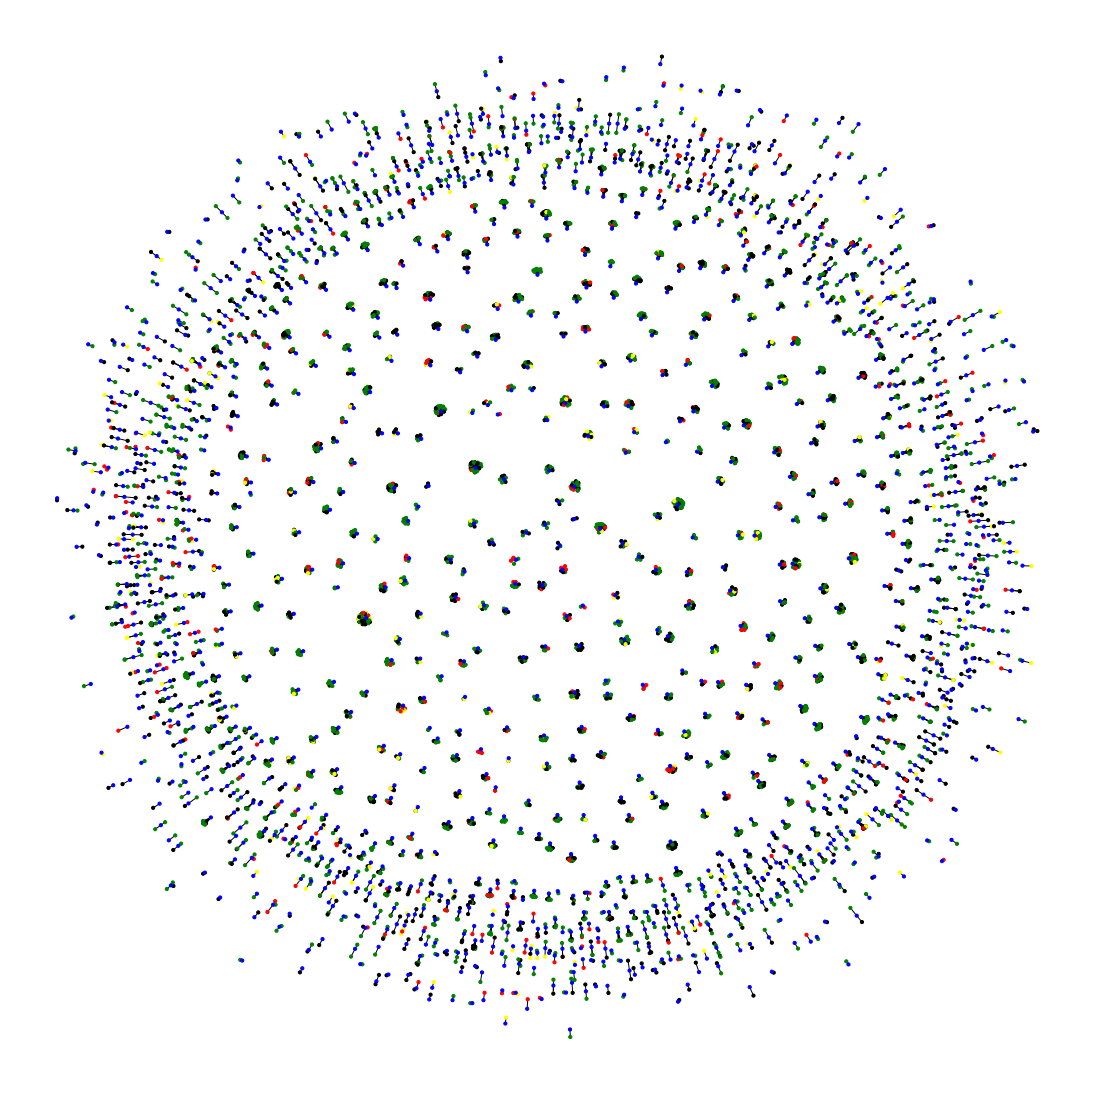

In [0]:
lim=5000
subreddit='CasualConversation'

G = nx.Graph()
df = labeled_comments[['sentenceid','id','support','disclosive','subreddit']]
if(subreddit is not None):
    df = df[df.subreddit==subreddit]
sentences=df.sentenceid.to_numpy()
print(sentences.shape)
G.add_nodes_from(sentences[:lim])
G.add_edges_from(df[['sentenceid','id']].to_numpy()[:lim])
G.nodes()
df.loc[df.support==1,'colour'] = 'red'
df.loc[(df.disclosive==1)&(df.colour=='red'),'colour'] = 'yellow'
df.loc[(df.disclosive==1)&(df.colour!='yellow'),'colour'] = 'green'
df=df.fillna('black')
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=10 ,node_color=np.append(df.colour.to_numpy()[:lim],(["blue"]*(len(G)-lim))))
plt.show()
